In [64]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

In [65]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(6)

In [66]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [67]:
client

Client Scheduler: tcp://10.148.1.12:39880 Dashboard: http://10.148.1.12:53540/status,Cluster Workers: 6 Cores: 24 Memory: 300.00 GB


---


# 1. LLC results

In [82]:
face_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
E_dir = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/constant_window/'
D = [xr.open_zarr(E_dir+'E_rotary_zavg_openocean_f%02d_1080.zarr'%(face)) for face in face_all] # open-ocean
ds = xr.concat(D, dim='face')
rspectra_LLC = (ds.E*ds.A).sum(dim='face') / ds.A.sum(dim='face')
rspectra_LLC = rspectra_LLC.assign_coords(freq_cpd=rspectra_LLC.freq_time * 86400.) 
rspectra_LLC = rspectra_LLC.chunk({'freq_time': 1440, 'lat': 1}) 
df=rspectra_LLC.freq_time[1]-rspectra_LLC.freq_time[0]
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(rspectra_LLC.lat))
f_cpd = f*86400/2./np.pi
rspectra_LLC  = np.real(rspectra_LLC).rename('rspectra_LLC')

file_E = data_dir+'rspectra_LLC.zarr'
%time rspectra_LLC.to_dataset().to_zarr(file_E, mode='w')  
print(rspectra_LLC)

CPU times: user 708 ms, sys: 80 ms, total: 788 ms
Wall time: 1.23 s
<xarray.DataArray 'rspectra_LLC' (lat: 120, freq_time: 1439)>
dask.array<shape=(120, 1439), dtype=float64, chunksize=(1, 1439)>
Coordinates:
  * freq_time  (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat        (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 -52.5 ...
    freq_cpd   (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>


In [84]:
rspectra_LLC = xr.open_zarr(data_dir+'rspectra_LLC.zarr').chunk({'freq_time': 1439, 'lat': 1}) 
print(rspectra_LLC)
rspectra_LLC  = rspectra_LLC.rspectra_LLC

<xarray.Dataset>
Dimensions:       (freq_time: 1439, lat: 120)
Coordinates:
    freq_cpd      (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>
  * freq_time     (freq_time) float64 -0.0001388 -0.0001386 -0.0001384 ...
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 -55.5 -54.5 -53.5 ...
Data variables:
    rspectra_LLC  (lat, freq_time) float64 dask.array<shape=(120, 1439), chunksize=(1, 1439)>


_________
# 2. Drifter Results

In [70]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds_linear_window = xr.open_zarr(data_dir+'E_drifter_linear_window_forcharles.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
rspectra_drifter  = ds_linear_window.E_drifter_linear_window
rspectra_drifter  = np.real(rspectra_drifter).rename('rspectra_drifter')
print(rspectra_drifter)
file_E = data_dir+'rspectra_drifter.zarr'
%time rspectra_drifter.to_dataset().to_zarr(file_E, mode='w')  

<xarray.DataArray 'rspectra_drifter' (lat_bins: 120, freq_time: 1440)>
dask.array<shape=(120, 1440), dtype=float64, chunksize=(1, 1440)>
Coordinates:
    freq_cpd           (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
  * lat_bins           (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 -55.5 ...
CPU times: user 940 ms, sys: 100 ms, total: 1.04 s
Wall time: 6.75 s


In [75]:
rspectra_drifter = xr.open_zarr(data_dir+'rspectra_drifter.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
print(rspectra_drifter)
rspectra_drifter  = rspectra_drifter.rspectra_drifter


<xarray.Dataset>
Dimensions:            (freq_time: 1440, lat_bins: 120)
Coordinates:
    freq_cpd           (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
  * lat_bins           (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 -55.5 ...
Data variables:
    rspectra_drifter   (lat_bins, freq_time) float64 dask.array<shape=(120, 1440), chunksize=(1, 1440)>


# 3. Figure

Text(0.5,1,'Drifter (drogued)')

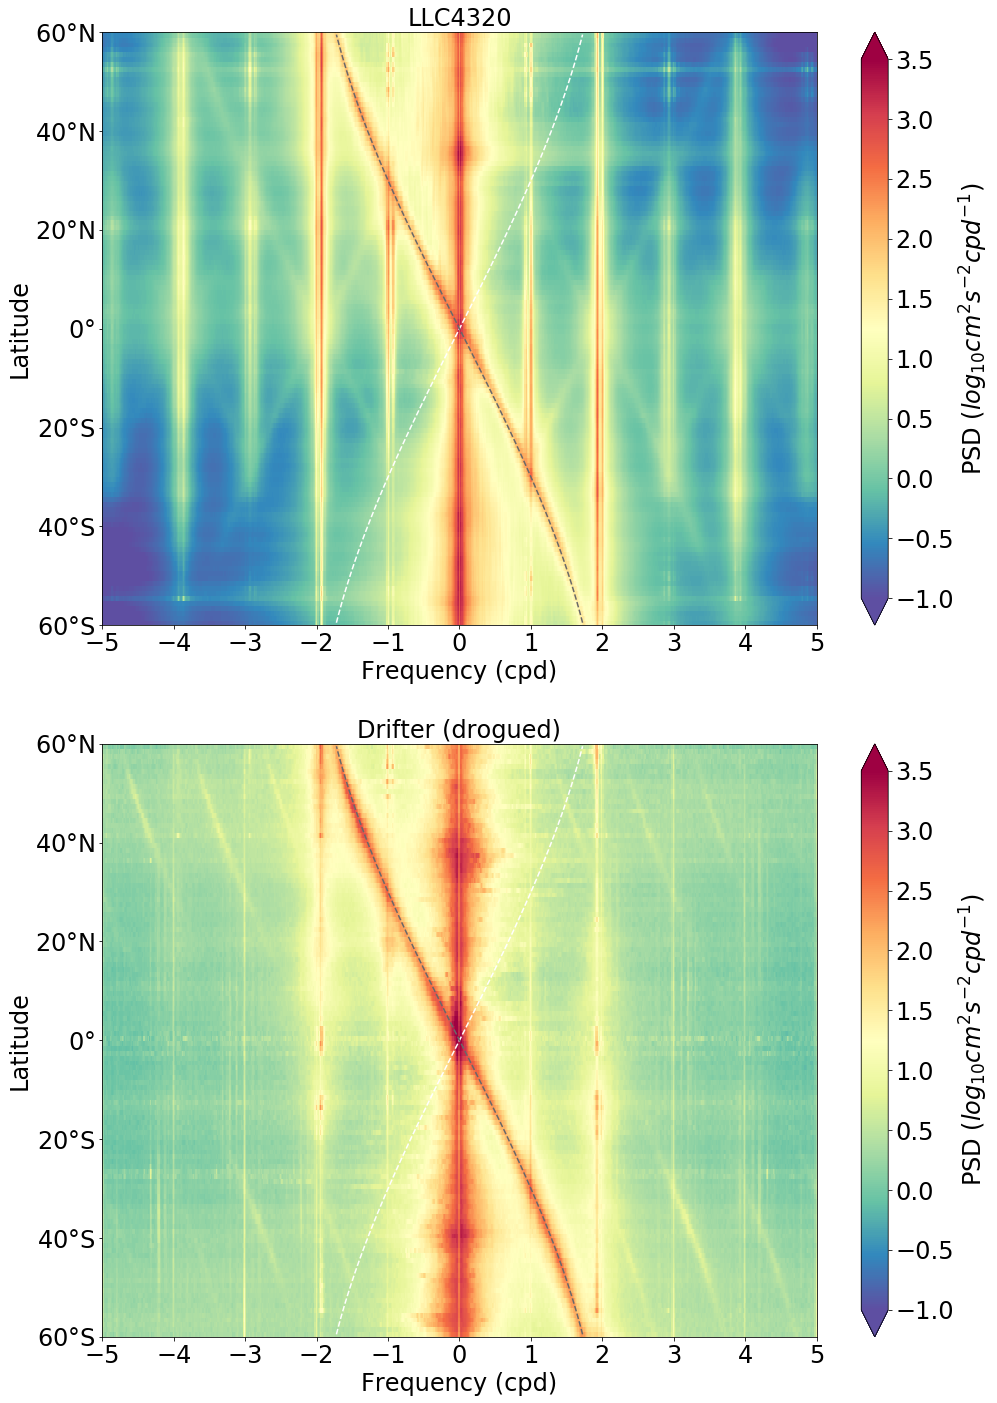

In [85]:
font_size = 24

fig, ax = plt.subplots(figsize=(16,24))


# LLC4320
ax = plt.subplot(2,1,1)
rspectra_LLC = rspectra_LLC.assign_coords(freq_cpd=rspectra_LLC.freq_time * 86400.) 
cax = np.log10(rspectra_LLC/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=3.5, x='freq_cpd', y='lat', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=24)
# add coriolis frequency
f = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(rspectra_LLC.lat))
ax.plot(f*86400./2./np.pi,f.lat,'w--')
ax.plot(-f*86400./2./np.pi,f.lat,'--',color='dimgrey')
ax.set_title('LLC4320',fontsize=font_size)


# Drifters
ax = plt.subplot(2,1,2)
cax = np.log10(rspectra_drifter.sortby('freq_time')/8.64).plot.pcolormesh(ax=ax, vmin=-1, vmax=3.5, x='freq_cpd', y='lat_bins', cmap = 'Spectral_r', add_colorbar = False)
# colorbar
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('PSD ($log_{10} cm^2 s^{-2} cpd^{-1})$', fontsize=font_size)
# x,y ticks
ax.set_xticks(list(ax.get_xticks()) + [-4., -3., -2., -1., 1., 2., 3., 4.])
ax.set_xlim(-5., 5.)
ax.set_ylim(-60., 60.)
ax.set_yticks([-60., -40., -20., 0., 20., 40., 60.])
#ax.set_yticklabels(['60S','40S','20S','0','20N','40N','60N'])
ax.set_yticklabels(['$60\degree$S','$40\degree$S','$20\degree$S','$0\degree$','$20\degree$N','$40\degree$N','$60\degree$N'])
ax.set_ylabel('Latitude',fontsize=font_size)
ax.set_xlabel('Frequency (cpd)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
# add coriolis frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(rspectra_drifter.lat_bins))
ax.plot(f_drifter*86400./2./np.pi,f_drifter.lat_bins,'w--')
ax.plot(-f_drifter*86400./2./np.pi,f_drifter.lat_bins,'--',color='dimgrey')
ax.set_title('Drifter (drogued)',fontsize=font_size)



# 1. Drifter data files

In [41]:
# The prcessed dataset includes both the GPS- and Argo-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'

drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude over 60 days,     157978*1
# mlon2: mean longitude over 60 days,    157978*1

# qd: drogued drifters,                  157978*1
# qmed200: median water depth > 200 m,   157978*1
# qu: undrogued drifters,                157978*1

# uv2: (u, v),                           157978*1440

[('dpth2', <HDF5 dataset "dpth2": shape (157978, 1440), type "<f8">),
 ('lat2_err', <HDF5 dataset "lat2_err": shape (157978, 1440), type "<f8">),
 ('lon2_err', <HDF5 dataset "lon2_err": shape (157978, 1440), type "<f8">),
 ('mdpth', <HDF5 dataset "mdpth": shape (157978, 1), type "<f8">),
 ('mlat2', <HDF5 dataset "mlat2": shape (157978, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (157978, 1), type "<f8">),
 ('qall1000', <HDF5 dataset "qall1000": shape (157978, 1), type "|u1">),
 ('qall200', <HDF5 dataset "qall200": shape (157978, 1), type "|u1">),
 ('qall500', <HDF5 dataset "qall500": shape (157978, 1), type "|u1">),
 ('qd', <HDF5 dataset "qd": shape (157978, 1), type "|u1">),
 ('qmed1000', <HDF5 dataset "qmed1000": shape (157978, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (157978, 1), type "|u1">),
 ('qmed500', <HDF5 dataset "qmed500": shape (157978, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (157978, 1), type "|u1">),
 ('u2_err', <HDF5 dataset

In [42]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 157978)>
array([ 44.219853,  44.908928,  44.856863, ..., -37.524563, -37.171366,
       -37.194084])
Dimensions without coordinates: lat

In [43]:
# turn mean-lat into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 157978)>
array([307.992707, 306.962722, 305.597501, ..., 325.844828, 326.138668,
       325.506414])
Dimensions without coordinates: lon

In [44]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 157978)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [45]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((157978, 1440, 2))
uv_drifters = uv[:,:,0] + 1j*uv[:,:,1]
uv_drifters.shape  # result is (10, 10, 10)
uv_drifters

array([[-0.2048+0.4936j, -0.3023+0.4859j, -0.2971+0.4856j, ...,
         0.1322+0.009j ,  0.1219-0.0239j, -0.0805-0.1172j],
       [ 0.1436+0.2085j,  0.1056+0.1783j,  0.0387+0.128j , ...,
         0.116 +0.075j ,  0.0779+0.2255j,  0.1379+0.195j ],
       [-0.1518-0.1663j, -0.1137-0.1704j, -0.1083-0.1446j, ...,
        -0.2145-0.3872j, -0.215 -0.3862j, -0.2145-0.3976j],
       ...,
       [ 0.3967+0.1554j,  0.4447+0.1624j,  0.4864+0.1736j, ...,
         0.072 +0.2357j,  0.0712+0.2299j,  0.0676+0.2051j],
       [ 0.1061+0.0992j,  0.074 +0.0919j,  0.0629+0.096j , ...,
         0.0589+0.0466j,  0.0513+0.0552j,  0.0395+0.0682j],
       [ 0.0622+0.164j ,  0.0589+0.1348j,  0.0671+0.121j , ...,
        -0.1189+0.0092j, -0.1027-0.0244j, -0.0739-0.0525j]])

In [46]:
# Drifter Dataset (u+iv,lat,qd,time)
ds = xr.Dataset({'uv_drifters': (['lat', 'time'], uv_drifters)},
                
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd)})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 157978, time: 1440)
Coordinates:
  * lat          (lat) float64 44.22 44.91 44.86 43.76 42.22 46.44 46.08 ...
    lon          (lat) float64 308.0 307.0 305.6 305.5 309.8 307.8 307.6 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 ...
Data variables:
    uv_drifters  (lat, time) complex128 (-0.2048+0.4936j) (-0.3023+0.4859j) ...

 data size: 3.6 GB


_________
# 2. Rotary spectra of Drifter uv

## raw drogued drifters

## linear detrending and Hanning windowing

### Drogued drifters

In [47]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where(ds.qd>0).fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_zonmean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(-60., 60.5, 1), labels=np.arange(-59.5, 60, 1)).mean(dim=['lat']))

E_drifter_linear_window = E_uv_zonmean#.load()
E_drifter_linear_window = np.real(E_drifter_linear_window).rename('E_drifter_linear_window')
file_E = data_dir+'E_drifter_linear_window_forcharles.zarr'
%time E_drifter_linear_window.to_dataset().to_zarr(file_E, mode='w') 
print(E_drifter_linear_window)

CPU times: user 1.49 s, sys: 100 ms, total: 1.59 s
Wall time: 59.4 ms
<xarray.DataArray 'E_drifter_linear_window' (lat_bins: 120, freq_time: 1440)>
array([[1717.545467, 5195.858884, 5435.309011, ..., 4318.254987, 4872.804495,
        4362.969694],
       [2117.836486, 5932.966952, 6664.371628, ..., 6106.415228, 6836.875017,
        6148.201417],
       [2539.646973, 6478.462956, 6424.355864, ..., 6469.237198, 6885.777719,
        5899.57606 ],
       ...,
       [1277.64775 , 3729.830322, 3838.471638, ..., 2699.119365, 2751.959996,
        2644.010506],
       [1277.114179, 3812.252713, 3776.36598 , ..., 2684.465139, 3330.944442,
        2866.258309],
       [1234.748443, 3624.093405, 3400.288399, ..., 2362.644358, 2587.16606 ,
        2747.094201]])
Coordinates:
  * lat_bins           (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 -55.5 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq

In [51]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds_linear_window = xr.open_zarr(data_dir+'E_drifter_linear_window_forcharles.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
rspectra_drifter  = ds_linear_window.E_drifter_linear_window
rspectra_drifter  = np.real(rspectra_drifter).rename('rspectra_drifter')
print(ds_linear_window)

<xarray.Dataset>
Dimensions:                  (freq_time: 1440, lat_bins: 120)
Coordinates:
    freq_cpd                 (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time                (freq_time) float64 0.0 1.929e-07 3.858e-07 ...
    freq_time_spacing        float64 ...
  * lat_bins                 (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 ...
Data variables:
    E_drifter_linear_window  (lat_bins, freq_time) float64 dask.array<shape=(120, 1440), chunksize=(1, 1440)>


In [87]:
cluster.scheduler.close()

<Future finished result=None>